In [1]:
#!pip3 install autokeras
#!pip3 install matplotlib

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

import logging
logging.getLogger('tensorflow').disabled = True

from sklearn.datasets import load_files
from tensorflow.keras.datasets import mnist
import autokeras as ak

import plotly.express as px
import copy 
import os
import json

from mylib import plot_roc, plot_pr_curve, plot_roc_train_test, plot_pr_train_test, hyper_table, predic_error_analysis, plot_pr_multi_class

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## A Simple Example
The first step is to prepare your data. Here we use the MNIST dataset as an example


The second step is to run the ImageClassifier.
It is recommended have more trials for more complicated datasets.
This is just a quick demo of MNIST, so we set max_trials to 1.
For the same reason, we set epochs to 10.
You can also leave the epochs unspecified for an adaptive number of epochs.


In [4]:
data = pd.read_csv('new_multiclasses.csv')
data

,file,blank,ps1,ps2,multi,ice,badice,mos1,mos2,Y
0,fake_00001.pgm,0,1,0,0,1,0,0.892528,0.000000,ps1+ice
1,fake_00002.pgm,0,0,1,1,0,0,0.581729,0.568217,ps2+multi
2,fake_00003.pgm,0,1,0,0,0,0,0.508285,0.000000,ps1
3,fake_00004.pgm,0,1,0,0,0,0,0.852589,0.000000,ps1
4,fake_00005.pgm,0,0,1,0,0,0,0.762097,0.000000,ps2
...,...,...,...,...,...,...,...,...,...,...
26573,fake_38737.pgm,0,1,0,0,0,0,0.897076,0.000000,ps1
26574,fake_38738.pgm,0,1,0,0,0,0,0.646006,0.000000,ps1
26575,fake_38740.pgm,0,1,1,1,0,0,0.529205,0.716043,ps1+ps2+multi
26576,fake_38741.pgm,0,1,0,0,0,0,0.752521,0.000000,ps1


In [5]:
lable_count = dict(data['Y'].value_counts())
lable_count

{'ps1': 9611,
 'ps1+ps2+multi': 5142,
 'ps2+multi': 2558,
 'ps1+multi': 2550,
 'ps1+ice': 1624,
 'ps2+ice': 1612,
 'ps2': 1589,
 'ps1+ps2+multi+ice': 869,
 'ps2+multi+ice': 420,
 'ps1+multi+ice': 397,
 'blank': 77,
 'ps1+ps2': 75,
 'ps1+ps2+ice': 26,
 'ps2+ice+badice': 13,
 'ps1+ice+badice': 7,
 'ps2+multi+ice+badice': 4,
 'ps1+multi+ice+badice': 2,
 'ps1+ps2+multi+ice+badice': 2}

In [6]:
new_data = pd.concat([data[data['Y']==y][:100] if lable_count[y]>100 else data[data['Y']==y] for y in np.unique(data['Y'])])
new_data

,file,blank,ps1,ps2,multi,ice,badice,mos1,mos2,Y
435,fake_00460.pgm,1,0,0,0,0,0,0.000000,0.000000,blank
455,fake_00482.pgm,1,0,0,0,0,0,0.000000,0.000000,blank
471,fake_00499.pgm,1,0,0,0,0,0,0.000000,0.000000,blank
2195,fake_02901.pgm,1,0,0,0,0,0,0.000000,0.000000,blank
2284,fake_03040.pgm,1,0,0,0,0,0,0.000000,0.000000,blank
...,...,...,...,...,...,...,...,...,...,...
6019,fake_08555.pgm,0,0,1,1,1,0,0.850695,0.815657,ps2+multi+ice
13,fake_00014.pgm,0,0,1,1,1,1,0.516343,0.681703,ps2+multi+ice+badice
46,fake_00047.pgm,0,0,1,1,1,1,0.822762,0.710859,ps2+multi+ice+badice
114,fake_00115.pgm,0,0,1,1,1,1,0.603269,0.832699,ps2+multi+ice+badice


In [7]:
imgs = []
imgs_arr = []
imgs_drop = []
for f in new_data['file']:
    f = f.replace('pgm','png')
    try:
        image = tf.keras.preprocessing.image.load_img("./training_data/{}".format(f), color_mode='grayscale') 
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        imgs.append(image)
        imgs_arr.append(image_array)
    except:
        imgs_drop.append(f)
print(len(imgs_drop))

0


In [10]:
input_arr = np.array(imgs_arr)  # Convert single image to a batch.
print(type(input_arr))
print(input_arr.shape)
x_train = np.squeeze(input_arr)
print(x_train.shape)
y_train = np.array(new_data['Y'])
print(y_train.shape)
X = x_train
Y = y_train

<class 'numpy.ndarray'>
(1206, 512, 512, 1)
(1206, 512, 512)
(1206,)


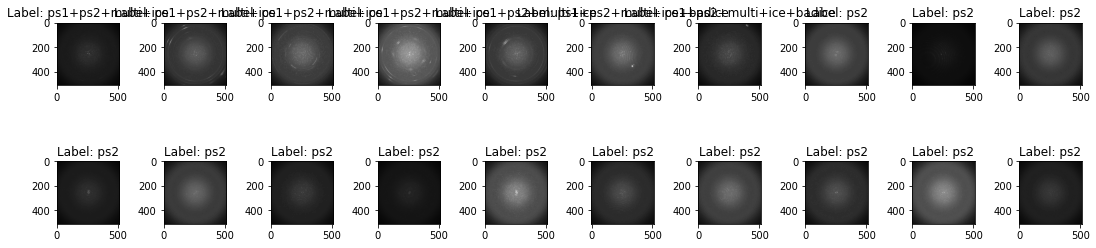

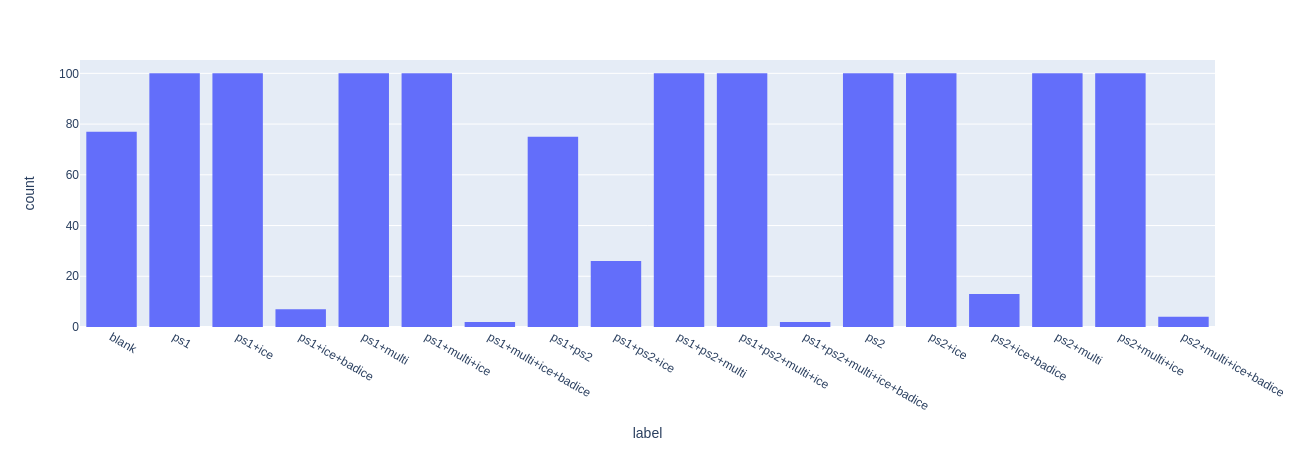

In [11]:
import matplotlib.pyplot as plt
num = 20
k=np.random.randint(len(y_train))
images = x_train[k:(k+num)]
labels = y_train[k:(k+num)]
num_row = 2
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

import plotly.express as px
df = pd.DataFrame(y_train, columns=['label'])
fig = px.histogram(df, x='label', nbins=10)
fig.show()

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=2)

# Feed the image classifier with training data. That's it!
clf.fit(x_train, y_train)


# Predict with the best model.
predicted_y = clf.predict(x_test)
print(predicted_y)


# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

Trial 1 Complete [00h 25m 19s]
val_loss: 2.3974950313568115

Best val_loss So Far: 2.3974950313568115
Total elapsed time: 00h 25m 19s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
image_block_1/b...|resnet            |vanilla           
image_block_1/n...|True              |True              
image_block_1/a...|True              |False             
image_block_1/i...|True              |None              
image_block_1/i...|True              |None              
image_block_1/i...|0                 |None              
image_block_1/i...|0                 |None              
image_block_1/i...|0.1               |None              
image_block_1/i...|0                 |None              
image_block_1/r...|False             |None              
image_block_1/r...|resnet50          |None              
image_block_1/r...|True              |None              
classification_...|global_avg        |flatten           
classification_...|0                 |0.5

KeyboardInterrupt: 

In [ ]:
# performance of the model
display(hyper_table(path='image_classifier'))

model = clf.export_model()
model.summary()

y_score_test = model.predict(x_test)
y_score_train = model.predict(x_train)

In [ ]:
plot_pr_multi_class(y_train, y_score_train, y_test, y_score_test)